# Two sample permutation test of respiratory phase angles
This notebook runs permutation tests to compare two samples of respiratory phase angles. This is useful when you want to compare the phase angles of two different conditions or groups.

In [48]:
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


from pyriodic.viz import CircPlot
from pyriodic.permutation import permutation_test_between_samples

## Single-level analysis


In [49]:
data_path = Path("../../data/respiration/intermediate")
subj_id = "0019"
file_path = data_path / f"participant_{subj_id}_preproc.pkl"

with open(file_path, 'rb') as f:
            data = pickle.load(f)

circ = data["circ"]
PA = data["phase_angles"]


## Choosing events of interest and plotting the two samples

In [50]:
targets_weak = circ["weak/target"]


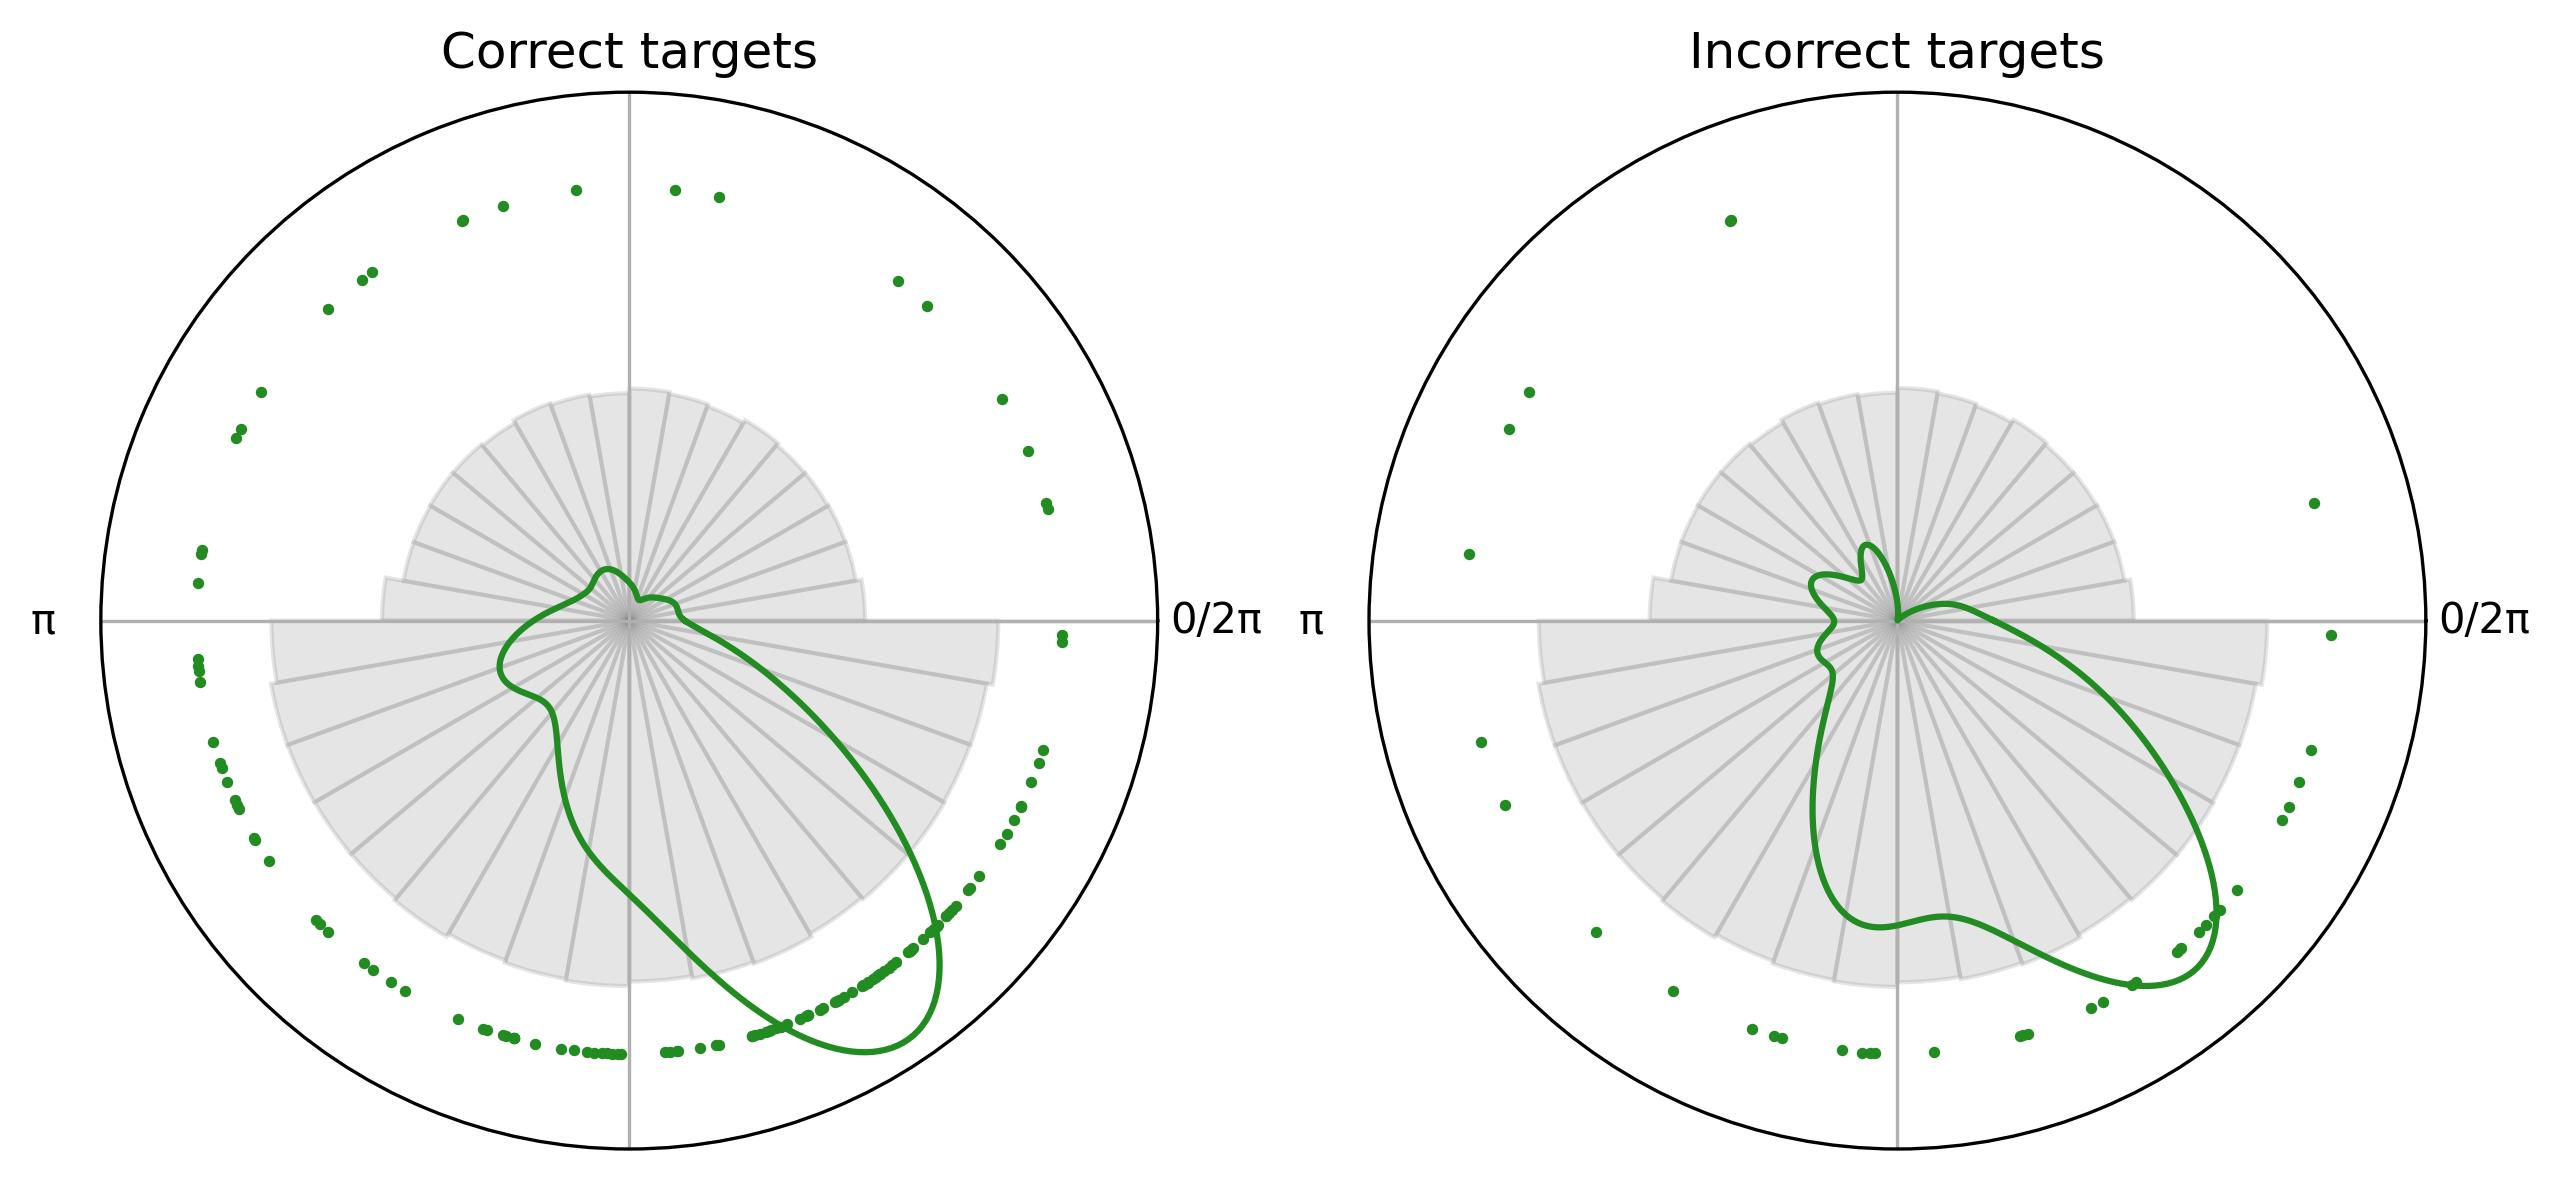

In [51]:
correct_targets = targets_weak["correct"]
incorrect_targets = targets_weak["incorrect"]

fig, axes = plt.subplots(1, 2, dpi = 300, figsize = (10, 6), subplot_kw={"projection": "polar"}, sharey=True)

correct_plot = CircPlot(
    correct_targets, 
    title = "Correct targets",
    group_by_labels=False, 
    ax=axes[0]
)
correct_plot.add_points(s=3)
correct_plot.add_density()
correct_plot.add_histogram(PA)


incorrect_plot = CircPlot(
    incorrect_targets, 
    title = "Incorrect targets",
    group_by_labels=False, 
    ax=axes[1]
)
incorrect_plot.add_points(s=3)
incorrect_plot.add_density()
incorrect_plot.add_histogram(PA)

In [52]:
# Run permutation test
obs_stat, pval = permutation_test_between_samples(
    correct_targets.data,
    incorrect_targets.data,
    n_permutations=10000
)

Observed statistic = 0.040, p = 0.8418


In [53]:
circs = {}
for file_path in data_path.iterdir(): 
    subj_id = file_path.name.split("_")[1]
    with open(file_path, 'rb') as f:
            data = pickle.load(f)

    circs[subj_id] = data["circ"]


n_permutations = 1000

group_observed_stats = []
group_null_stats = []
group_pvals = []


for subj_id in circs:
    pa = circs[subj_id]
    weak_targets = circs[subj_id]["weak/target"]
    
    correct_targets_tmp = weak_targets["correct"]
    incorrect_targets_tmp = weak_targets["irregular"]

    # Run subject-level permutation test
    obs, pval, null_distribution = permutation_test_between_samples(
        incorrect_targets_tmp.data,
        correct_targets_tmp.data,
        n_permutations=n_permutations,
        verbose=False,
        return_null_distribution=True,
    )

    group_observed_stats.append(obs)
    group_null_stats.append(null_distribution)
    group_pvals.append(pval)


# Group-level observed statistic: average of subject-level observed stats
# On average, do subjects show evidence of difference in phase for irregular and regular targets?
group_obs = np.mean(group_observed_stats)

# Group-level null: average of null stats across subjects, per null_stat
# Reference distribution of what kind of group-level effect you’d expect if there was no difference between irregular and regular targets
group_null = [
    np.mean([nulls[i] for nulls in group_null_stats])
    for i in range(n_permutations)
]

# Group-level p-value
p_val = (np.sum(np.array(group_null) >= group_obs) + 1) / (len(group_null) + 1)

print(f"Group-level statistic = {group_obs:.3f}, p = {p_val:.4f}")


Group-level statistic = 0.024, p = 1.0000


## Another example where there is a difference between the two samples

Observed statistic = 0.748, p = 0.0001


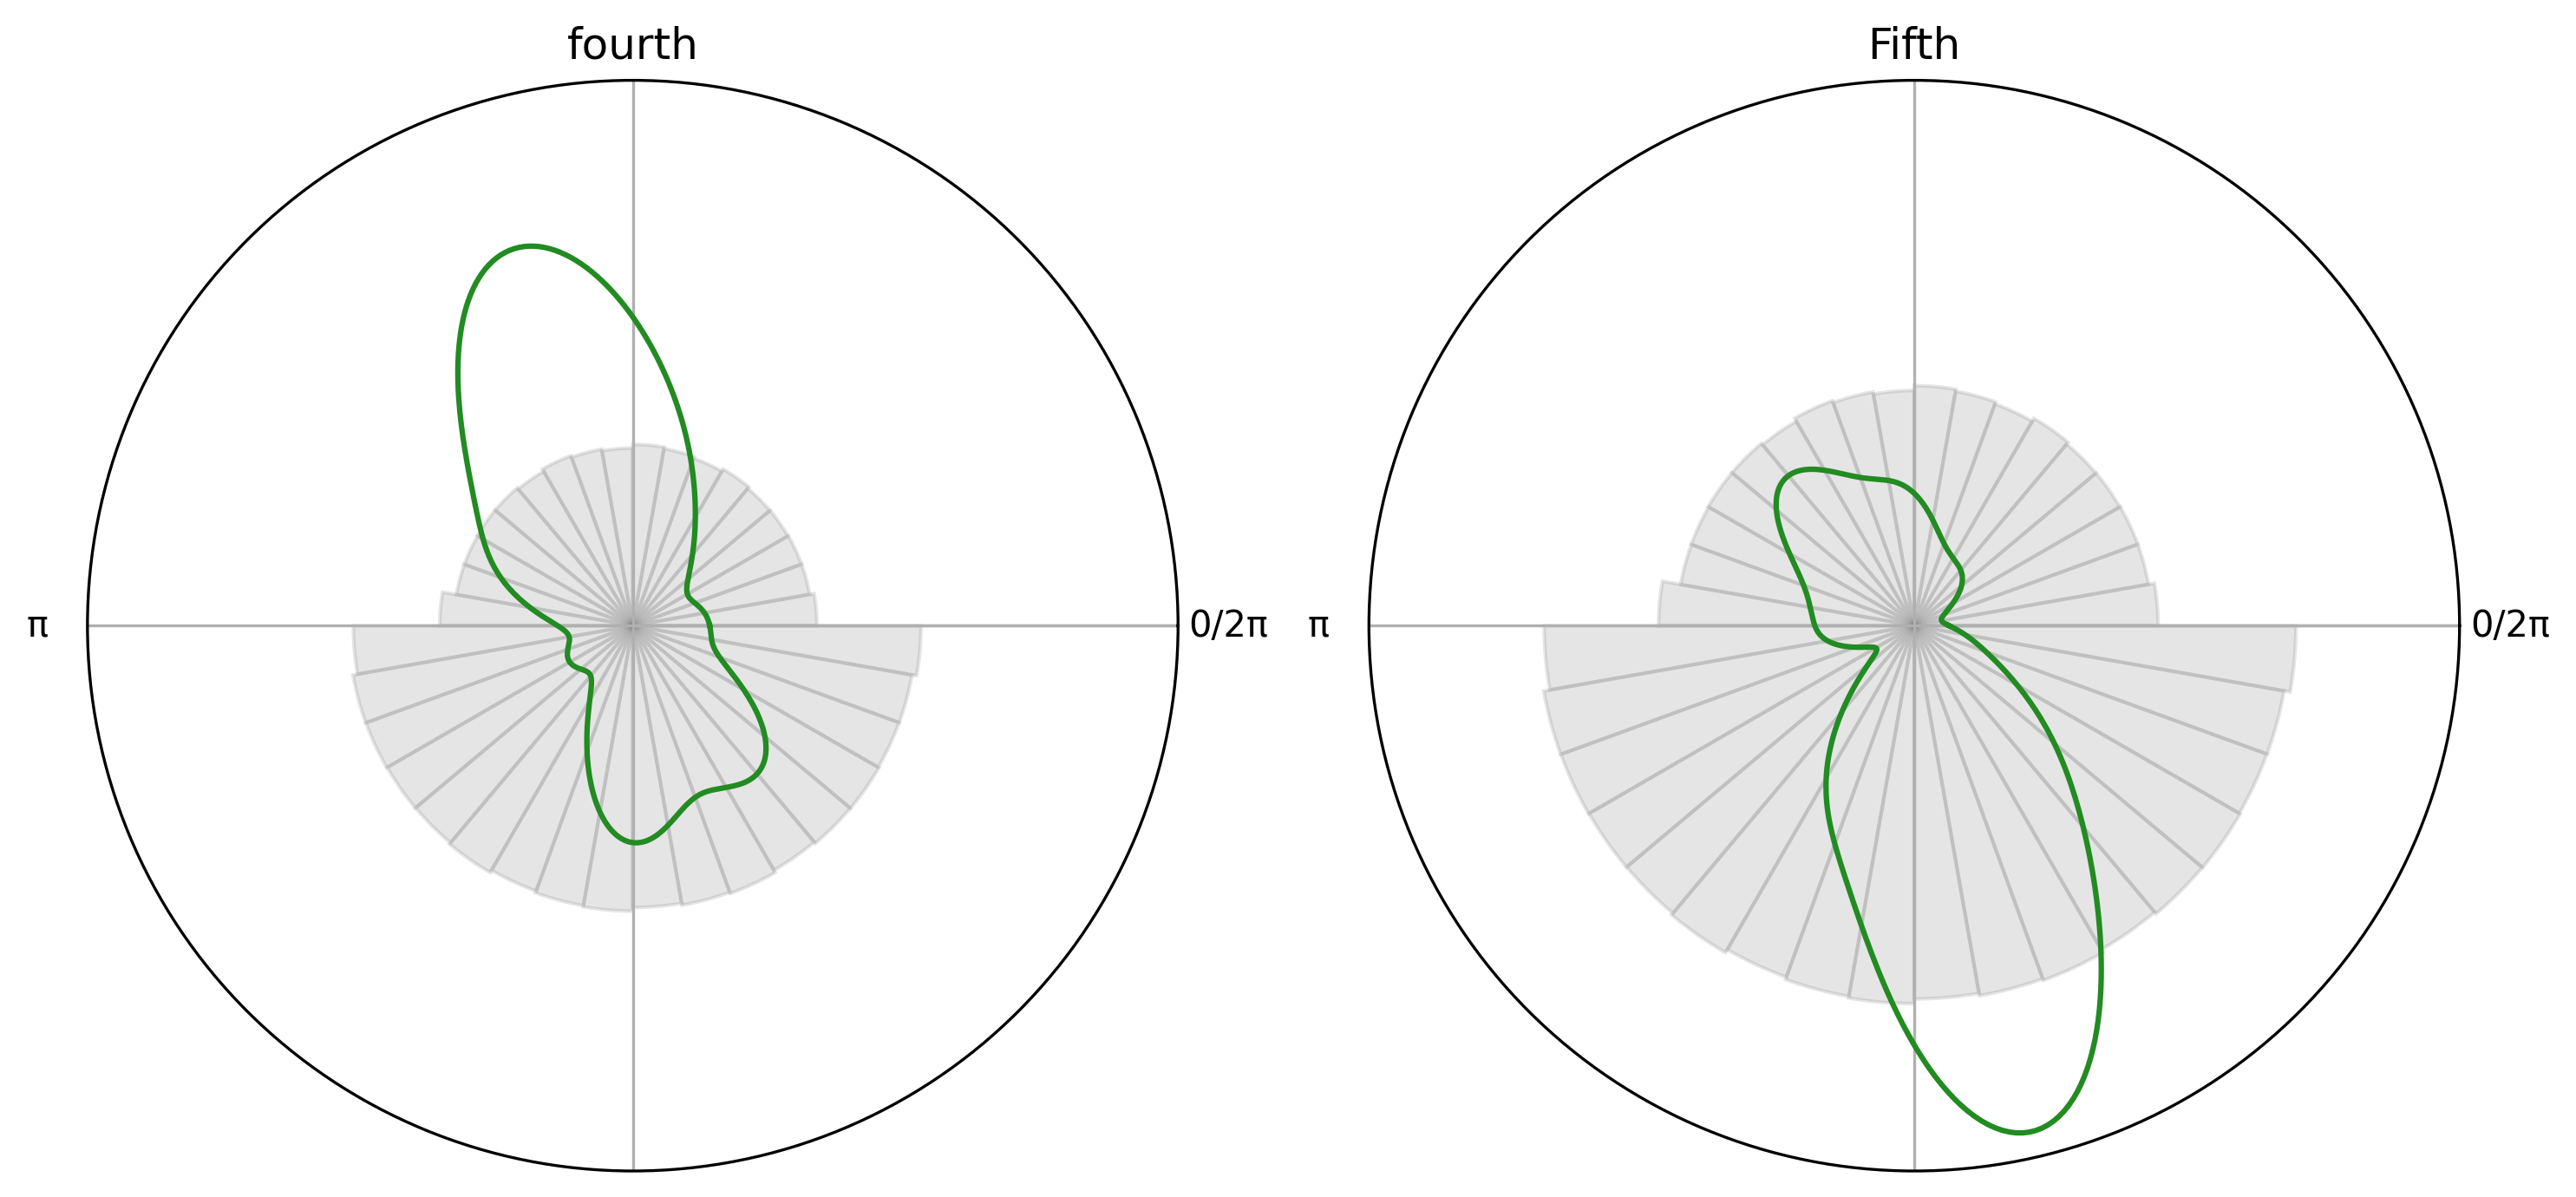

In [54]:
fourth_salient = circ["salient/regular/fourth"]
fifth_salient = circ["salient/regular/fifth"]


fig, axes = plt.subplots(1, 2, dpi = 300, figsize = (10, 6), subplot_kw={"projection": "polar"}, sharey=True, sharex=True)

fourth_plot = CircPlot(
    fourth_salient, 
    title="fourth",
    group_by_labels=False, 
    ax=axes[0]
)
fourth_plot.add_density()
fourth_plot.add_histogram(PA)



fifth_plot = CircPlot(
    fifth_salient, 
    title="Fifth",
    group_by_labels=False, 
    ax=axes[1]
)
fifth_plot.add_density()
fifth_plot.add_histogram(PA)

plt.tight_layout()

# Run permutation test
obs_stat, pval = permutation_test_between_samples(
    fourth_salient.data,
    fifth_salient.data,
    n_permutations= 10000,
)